#### Student Name:
#### Student ID:

# CSE 190 Assignment 3

### Audio SVD and PCA with Auto Encoder

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook as a PDF.

## Learning Audio Components using SVD

SVD decomposes the data matrix X into 3 matrices $$\mathbf{X} = \mathbf{U}\mathbf{D}\mathbf{V^T}$$

**D** is a diagonal matrix. Each element **D[i,i]** is fraction of the overall standard deviation in the data due to contribution of the element in column i of matrix **U**.

**U** becomes the new coordinate system (basis), and the coordinates of each data sample in **X** are given by rows of **V**.

This technique is also closely related to sub-space projection methods for denoising.  
Let us create a synthetic sound example comprising of a sinusoid with noise.

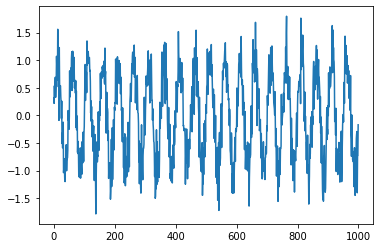

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys

fs = 10000
f0 = 200
T = 3
Ns = fs*T
s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)
n = np.random.randn(Ns)
x = s + 0.3*n 


plt.plot(x[:1000])

wavfile.write('out1.wav', fs, x)

The first step in audio processing is cutting it into separate frames, also known as "audio vectors".

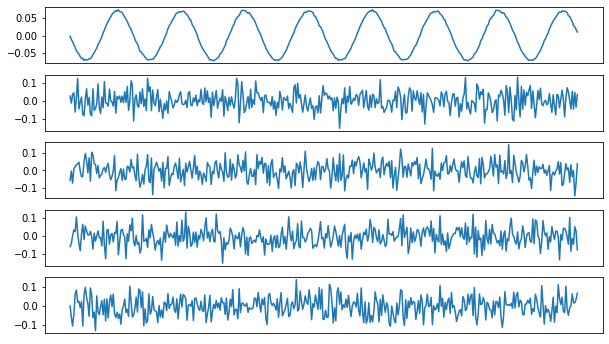

In [3]:
def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T


xmat = buffer(x,fs,400,200)
U, D, V = svd(xmat)

plt.figure(figsize=(10, 6))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(U[:,i])
    plt.xticks([])

The contribution of each of the different factors are as follows

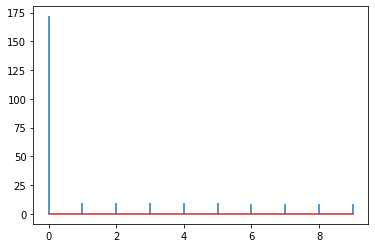

In [5]:
plt.stem(D[:10],markerfmt=' ',use_line_collection=True)
plt.show()

And here are the coefficients of each component (first 5) 

In [ ]:
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(V[i,:]*D[i])
    plt.axis([0,V.shape[0],-30,30])
    plt.xticks([])

As you can see, the coefficients of the components change over time, but the first two behave in very periodic manner, while the others are more random. It is important that we measure this predictability for distinction between structure and noise, especially in time-based signals. 

##### Question 1

Using the SVD of the noisy sinusoid, compute and plot a denoised version of the original signal.


In [ ]:
### Your code here: 



##### Question 2

Repeat the above analysis with f0 = 220 and again plot the first 4 basis vectors from matrix U.

What is different about the basis vectors? Why might this be occuring?


In [ ]:
### Your code & plots here

``` Your response here ```

##### Question 3

Repeat the original analysis, adding a second sine wave s2 to the original signal + noise. 

Plot the basis signals. 

Why does SVD find a combination signal in this case?

In [ ]:
### Your code & plots here

``` Your response here ```

## Estimating Structure in Time

The number of features is related to signal complexity. Their predictability is another important feature.

One powerful method is "spectral flatness". Lets do a simple version here

Here we plot rho which is a measure of predictability derived from SFM as 
$$ \rho = e^{-2*\small{SFM}}$$

See: http://en.wikipedia.org/wiki/Spectral_flatness
This measure is closely related to Information Rate.

Many issues related to perception of structure are based on a balance between complexity and predicability. 

Even our human perception of aesthetics seems to take these relations into account. Complex signals require an effort in terms of the resources needed to decode or represent them efficiently.

Predictability is related to our ability to form expectations and project the future. 
For a full discussion, please read Dubnov's "Spectral Anticipations" from the Computer Music Journal: http://musicweb.ucsd.edu/~sdubnov/InformationRate/CMJ_formated.pdf

Run the code in the cell below to see the spectral flatness of the rows of V (in other words, each coordinate of the data samples that make up X in basis U). 

In [ ]:
rho = np.zeros(10)
for i in range(10):
    Vft = abs(np.fft.rfft(V[i,:]))
    sf = gmean(Vft)/np.mean(Vft)
    rho[i] = np.exp(-2*sf)
    
plt.figure()
plt.stem(rho)

## Audio Basis and Karhunen-Loeve Transform

The decomoposition of our data matrix **X** into three matrices **X** = **UDV** can be also seen as a combination of two matrices: **U** that provides coordinates for a new space where data elements are combined differently and in more efficient way that allows also a lower-dimensional representation, and a set of coefficients **C** = **DV** that give the relative weights of each basis element over time.

Karhunen-Loeve Transform is closely related to PCA and SVD since it also uses eigen-decomposition to represent measurements in a lower dimensional space. Its main distinction is that it operates on random data vectors (patterns with probability function) and performs eigen-vector analysis on the correlation matrix **R**.

Relating this back to SVD is done by noticing that for **X** = **UDV**, the correlation matrix is approximated (up to division by number of frames) by **XX' = UD<sup>2</sup>U'** which has **U** as eigenvector **XX'U = UD<sup>2</sup>**

### Audio Basis
It is common in audio analysis to perform feature extraction not from signal data (samples) directly, but from FFT magnitude. In such case **X** would be a matrix containing the absolute values of Fourier Transform of short audio frames, also known as spectrogram. Thus our measurements or initial patterns are amplitudes of different frequency components, and each frame is considered as a separate experimental outcome. The correlation matrix **R** = E[**XX'**] is approximated by averaging over many such vectors.

Accordngly, **U** are sometimes called Audio Basis Vectors, and their linear combination is given by multiplying them by **V** with their relative "strengths" **D**. The elements of matrix **C** = **DV** are called "time coefficients" or "expension coefficients" for the audio basis **U**.

We will start by performing Short Time Fourier Analysis (stft) on a signal, and use normalized log-spectrum as our features. 

For this exercise, begin by reading the scale WAV file you recorded for Assignment 1. 

##### Question 4

In [ ]:
plt.rcParams['figure.figsize'] = (20, 6)

fs, x = wavfile.read('your_wav_file_here')

plt.plot(x)

In [ ]:
def stft(input_data, sample_rate, window_size, hop_size):
    window = scipy.hamming(window_size)
    output = scipy.array([scipy.fft(window*input_data[i:i+window_size]) 
                         for i in range(0, len(input_data)-window_size, hop_size)])
    return output

X = abs(stft(x, fs, 4096, 256)).T
X = np.log(X[:512,:])
Xmean = np.mean(X, axis = 1)
print(np.shape(X), np.shape(Xmean))
X = X - np.matrix(Xmean).T*np.matrix(np.ones(np.shape(X)[1]))
X = np.array(X)
D = np.diag(1/np.sqrt(sum(X**2,0))) 
Xnorm = np.dot(X,D)

plt.rcParams['figure.figsize'] = (20, 8)

plt.matshow(Xnorm,origin='lower')

### Computing Correlations

Now when we have our data processed to our satisfaction, we can start computing correlations betwen the rows or the colums of the data matrix.

Let us call **S** the product of rows, or along the time dimension, and **R** the product along columns, or the frequency dimension.

In [ ]:
R = np.dot(Xnorm,Xnorm.T)
print(R.shape)
plt.matshow(R,origin='upper')

In [ ]:
S = np.dot(Xnorm.T,Xnorm)
print(S.shape)
plt.matshow(S,origin='upper')

Both of these correlation matrices are important for extracting the essential information from our data. Matrix S captures similirities between the spectra across different time. This is easy to understand by visualizing it. In music, this is known as the "Self Similarity" matrix: http://en.wikipedia.org/wiki/Self-similarity_matrix

Matrix R captures correlations across frequencies, and we will use its most important dimensions, or principal vectors, to reduce the dimension of the data.

Next, we will apply SVD to this data matrix. We will reduce the number of elements (basis vectors) which will extract features by retaining fewer vectors with highest eignevalues (elements that contribute most to the variance).

##### Question 5

In [ ]:
U, D, V = ''' Your code here ''' 

U = np.matrix(U)
V = np.matrix(V)
Xnorm = np.matrix(Xnorm)

In [ ]:
s = 1
dim = 10

KLT = U[:,s:dim].T * X
Xdim = U[:,s:dim] * KLT

for i in np.arange(0,dim-s):
    plt.plot(np.array(KLT[i,:]).T, label=str(i))

###### Question 6

Ideally, we would want to use an algorithm that would extract the individual notes or components of this recording.
Based on the above graph, does KLT accomplish this? Please justify your answer. 

``` Your response here ```

# PCA with a Linear Autoencoder

Let's create the same sin+noise signal as before:

In [ ]:
f0 = 200
s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)
x = s + 0.3*n 

plt.plot(x[:1000])

wavfile.write('out2.wav', fs, x)

xmat = buffer(x,fs,400,200)

Here we create an AE with 2 or more hidden layers. 

This neural network is implemented in TensorFlow. 

Please review the code cells below, and answer the questions that follow. 

In [ ]:
import tensorflow as tf

n_inputs = np.shape(xmat)[0]
n_hidden = 2 

learning_rate = 0.01 

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
W = tf.Variable(tf.truncated_normal(stddev=.1, shape =[n_inputs,n_hidden]))

hidden = tf.matmul(X,W)
outputs = tf.matmul(hidden,tf.transpose(W))

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [ ]:
n_iterations = 10000
codings = hidden
X_train = xmat.T
X_test = X_train

col = ['b','r','g','c','m','y','k']

sess = tf.InteractiveSession()
init.run()
    
for iteration in range(n_iterations):
    training_op.run(feed_dict={X: X_train})

    if iteration %1000 == 0:
        W_val = W.eval()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden,1,k+1)
            plt.plot(W_val[:,k],col[k % len(col)])
        
        plt.show(False)
        plt.pause(0.001)

codings_val = codings.eval(feed_dict={X: X_test})

print("Done with training")

##### Question 6

Based on the observed shape of n_inputs and the definition of X_train, what is being passed to the input layer of the network for a single forward pass? 

``` Your response here ```

##### Question 7

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

``` Your response here ```

##### Question  8

What is being minimized in the reconstruction loss? Why is this helpful?

``` Your response here ```

##### Question 9

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training? 

``` Your response here ```

##### Question 10

Why is X_test set to X_train? 

``` Your response here ```

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more signigicant codings should have smaller variances.

In [ ]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

##### Question 11

If we were to use our trained autoencoder for PCA, how many principal components has our network learned?

``` Your response here ```